In [1]:

!wget --no-check-certificate https://files.grouplens.org/datasets/movielens/ml-100k.zip

!unzip ml-100k.zip

!ls ml-100k/

--2026-01-16 00:29:02--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.96.204
Connecting to files.grouplens.org (files.grouplens.org)|128.101.96.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  12.2MB/s    in 0.4s    

2026-01-16 00:29:02 (12.2 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.ba

In [2]:
import numpy as np
from scipy import sparse

def load():

    data = np.loadtxt('ml-100k/u.data')
    print(f"Загружено строк: {data.shape[0]}")

    ij = data[:, :2].astype(np.int64)
    ij -= 1

    values = data[:, 2].astype(np.int64)


    reviews = sparse.csc_matrix((values, ij.T), dtype=np.int64)

    return reviews.toarray()

reviews = load()
print(f"Размер матрицы оценок: {reviews.shape}")
print(f"Всего оценок: {np.sum(reviews > 0)}")
print(f"Разреженность: {np.sum(reviews > 0) / (reviews.shape[0] * reviews.shape[1]):.2%}")

Загружено строк: 100000
Размер матрицы оценок: (943, 1682)
Всего оценок: 100000
Разреженность: 6.30%


In [3]:
import random

def get_train_test(reviews=None, random_state=42):
    """Разделение данных на train/test (90%/10%)"""
    r = random.Random(random_state)

    if reviews is None:
        reviews = load()

    U, M = np.where(reviews)


    test_idxs = np.array(r.sample(range(len(U)), len(U)//10))


    train = reviews.copy()
    train[U[test_idxs], M[test_idxs]] = 0


    test = np.zeros_like(reviews)
    test[U[test_idxs], M[test_idxs]] = reviews[U[test_idxs], M[test_idxs]]

    print(f"Обучающая выборка: {np.sum(train > 0)} оценок")
    print(f"Тестовая выборка: {np.sum(test > 0)} оценок")

    return train, test

train, test = get_train_test(reviews, random_state=42)

Обучающая выборка: 90000 оценок
Тестовая выборка: 10000 оценок


In [4]:
class NormalizePositive(object):
    def __init__(self, axis=0):
        self.axis = axis

    def fit(self, features, y=None):
        if self.axis == 1:
            features = features.T


        binary = (features > 0)
        count0 = binary.sum(axis=0)
        count0[count0 == 0] = 1.


        self.mean = features.sum(axis=0) / count0


        diff = (features - self.mean) * binary
        diff **= 2
        self.std = np.sqrt(0.1 + diff.sum(axis=0) / count0)

        return self

    def transform(self, features):
        if self.axis == 1:
            features = features.T

        binary = (features > 0)
        features = features - self.mean
        features /= self.std
        features *= binary

        if self.axis == 1:
            features = features.T

        return features

    def inverse_transform(self, features, copy=True):
        if copy:
            features = features.copy()

        if self.axis == 1:
            features = features.T

        features *= self.std
        features += self.mean

        if self.axis == 1:
            features = features.T

        return features

    def fit_transform(self, features):
        return self.fit(features).transform(features)

norm = NormalizePositive(axis=0)
train_norm = norm.fit_transform(train)

binary = (train > 0)

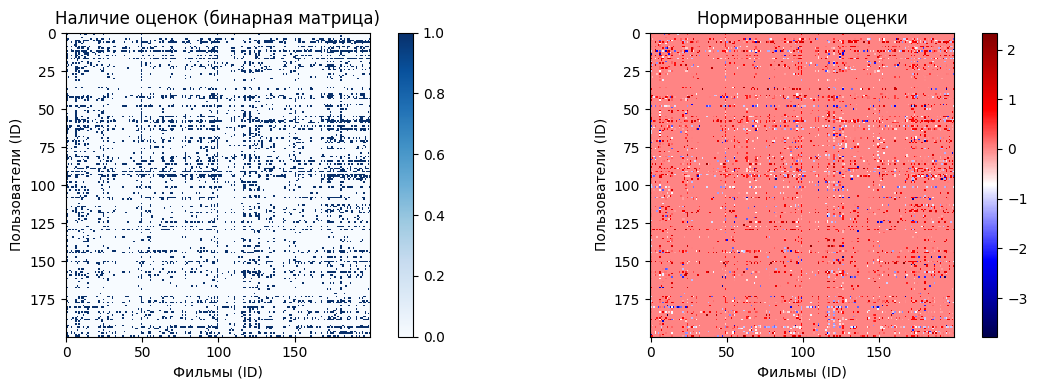

In [5]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(binary[:200, :200], interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.ylabel('Пользователи (ID)')
plt.xlabel('Фильмы (ID)')
plt.title('Наличие оценок (бинарная матрица)')

plt.subplot(1, 2, 2)
img = plt.imshow(train_norm[:200, :200], interpolation='nearest', cmap='seismic')
plt.colorbar(img)
plt.ylabel('Пользователи (ID)')
plt.xlabel('Фильмы (ID)')
plt.title('Нормированные оценки')

plt.tight_layout()
plt.show()

Топ 200 фильмов имеют от 137 до 523 оценок


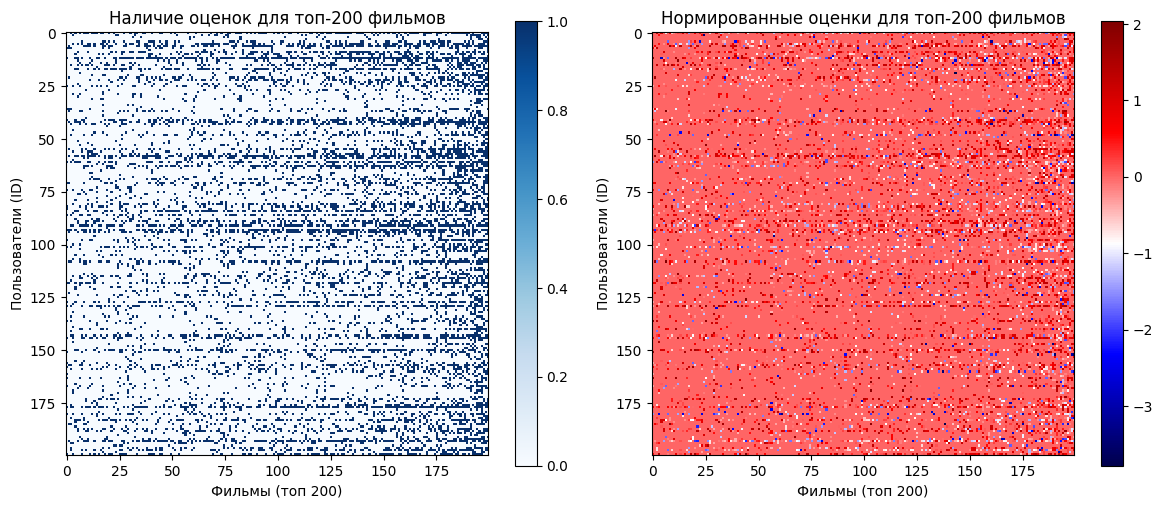

In [6]:

movie_ratings_count = np.sum(binary, axis=0)

top_200_movies_idx = np.argsort(movie_ratings_count)[-200:]

train_top200 = train_norm[:, top_200_movies_idx]
binary_top200 = binary[:, top_200_movies_idx]
test_top200 = test[:, top_200_movies_idx]

print(f"Топ 200 фильмов имеют от {movie_ratings_count[top_200_movies_idx[0]]} до "
      f"{movie_ratings_count[top_200_movies_idx[-1]]} оценок")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(binary_top200[:200, :], interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.ylabel('Пользователи (ID)')
plt.xlabel('Фильмы (топ 200)')
plt.title('Наличие оценок для топ-200 фильмов')

plt.subplot(1, 2, 2)
plt.imshow(train_top200[:200, :], interpolation='nearest', cmap='seismic')
plt.colorbar()
plt.ylabel('Пользователи (ID)')
plt.xlabel('Фильмы (топ 200)')
plt.title('Нормированные оценки для топ-200 фильмов')

plt.tight_layout()
plt.show()

Загружено информации о 1682 фильмах
Доступные жанры: ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
Найдено 725 фильмов жанра 'Drama'


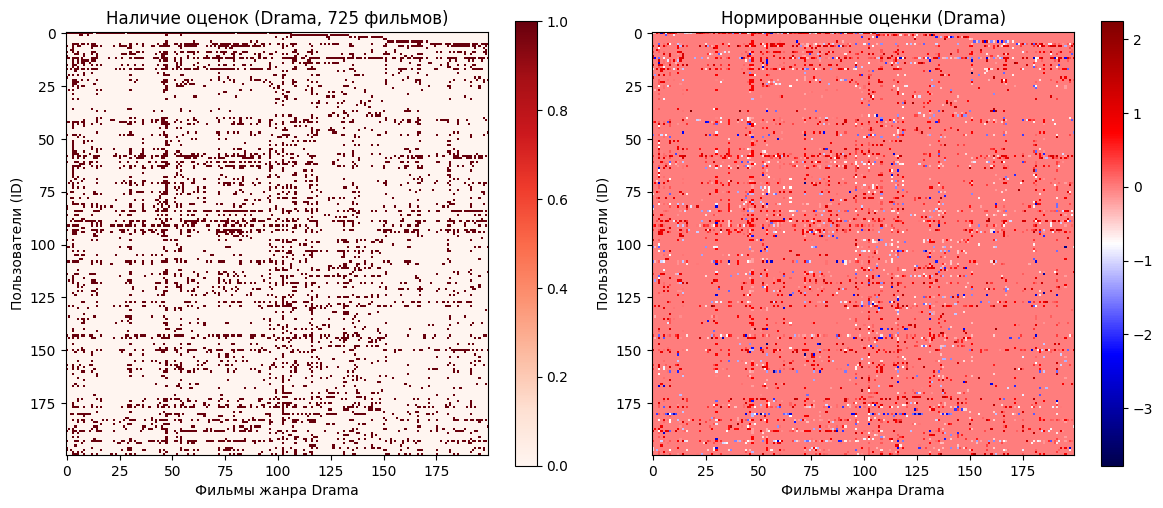

In [7]:

import pandas as pd

movies_info = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1', header=None)
print(f"Загружено информации о {movies_info.shape[0]} фильмах")

genres = ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
          'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
          'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

print("Доступные жанры:", genres)

genre_name = 'Drama'
genre_idx = genres.index(genre_name) + 5

genre_movies_idx = movies_info[movies_info[genre_idx] == 1].index.values

print(f"Найдено {len(genre_movies_idx)} фильмов жанра '{genre_name}'")

train_genre = train_norm[:, genre_movies_idx]
binary_genre = binary[:, genre_movies_idx]
test_genre = test[:, genre_movies_idx]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(binary_genre[:200, :200], interpolation='nearest', cmap='Reds')
plt.colorbar()
plt.ylabel('Пользователи (ID)')
plt.xlabel('Фильмы жанра ' + genre_name)
plt.title(f'Наличие оценок ({genre_name}, {len(genre_movies_idx)} фильмов)')

plt.subplot(1, 2, 2)
plt.imshow(train_genre[:200, :200], interpolation='nearest', cmap='seismic')
plt.colorbar()
plt.ylabel('Пользователи (ID)')
plt.xlabel('Фильмы жанра ' + genre_name)
plt.title(f'Нормированные оценки ({genre_name})')

plt.tight_layout()
plt.show()

In [8]:
from scipy.spatial import distance
from sklearn import metrics
import time

def build_user_based_model(train_data, binary_data, norm_obj, k_neighbors=5):
    """Модель на основе похожести пользователей"""
    print("Вычисление попарных расстояний между пользователями...")
    start_time = time.time()

    dists = distance.pdist(binary_data, 'correlation')
    dists = distance.squareform(dists)

    neighbors = dists.argsort(axis=1)

    print(f"Время вычисления расстояний: {time.time() - start_time:.1f} сек")

    filled = train_data.copy()

    print("Заполнение пропущенных оценок...")
    start_fill = time.time()

    for u in range(filled.shape[0]):
        n_u = neighbors[u, 1:k_neighbors+1]

        for m in range(filled.shape[1]):
            if not binary_data[u, m]:

                revs = [train_data[neigh, m] for neigh in n_u if binary_data[neigh, m]]

                if len(revs) > 0:
                    filled[u, m] = np.mean(revs)

    print(f"Время заполнения: {time.time() - start_fill:.1f} сек")

    return filled

def build_item_based_model(train_data, binary_data, norm_obj, k_neighbors=5):
    """Модель на основе похожести фильмов"""
    print("Вычисление попарных расстояний между фильмами...")
    start_time = time.time()


    train_t = train_data.T
    binary_t = binary_data.T


    dists = distance.pdist(binary_t, 'correlation')
    dists = distance.squareform(dists)


    neighbors = dists.argsort(axis=1)

    print(f"Время вычисления расстояний: {time.time() - start_time:.1f} сек")


    filled_t = train_t.copy()

    print("Заполнение пропущенных оценок...")
    start_fill = time.time()

    for i in range(filled_t.shape[0]):
        n_i = neighbors[i, 1:k_neighbors+1]

        for u in range(filled_t.shape[1]):
            if not binary_t[i, u]:

                revs = [train_t[neigh, u] for neigh in n_i if binary_t[neigh, u]]

                if len(revs) > 0:
                    filled_t[i, u] = np.mean(revs)

    print(f"Время заполнения: {time.time() - start_fill:.1f} сек")

    return filled_t.T

In [9]:
def evaluate_model(predicted, test_data, norm_obj, model_name=""):
    """Оценка качества модели"""

    predicted_original = norm_obj.inverse_transform(predicted)


    test_mask = test_data > 0

    if np.sum(test_mask) == 0:
        print(f"{model_name}: Нет данных для оценки")
        return 0


    r2 = metrics.r2_score(test_data[test_mask], predicted_original[test_mask])
    mae = metrics.mean_absolute_error(test_data[test_mask], predicted_original[test_mask])
    mse = metrics.mean_squared_error(test_data[test_mask], predicted_original[test_mask])

    print(f"{model_name}:")
    print(f"  R² score: {r2:.3f} ({r2:.1%})")
    print(f"  MAE: {mae:.3f}")
    print(f"  MSE: {mse:.3f}")
    print(f"  RMSE: {np.sqrt(mse):.3f}")
    print(f"  Оценок для теста: {np.sum(test_mask)}")

    return r2


norm_original = NormalizePositive(axis=0)
norm_original.fit(train)

norm_top200 = NormalizePositive(axis=0)
norm_top200.fit(train[:, top_200_movies_idx])

norm_genre = NormalizePositive(axis=0)
norm_genre.fit(train[:, genre_movies_idx])


print("=" * 60)
print("ОРИГИНАЛЬНЫЙ НАБОР ДАННЫХ (все фильмы)")
print("=" * 60)


print("\n1. User-based модель:")
predicted_user_orig = build_user_based_model(norm_original.transform(train), binary, norm_original)
r2_user_orig = evaluate_model(predicted_user_orig, test, norm_original, "User-based")


print("\n2. Item-based модель:")
predicted_item_orig = build_item_based_model(norm_original.transform(train), binary, norm_original)
r2_item_orig = evaluate_model(predicted_item_orig, test, norm_original, "Item-based")


print("\n" + "=" * 60)
print("TOP 200 ФИЛЬМОВ (наиболее оцениваемые)")
print("=" * 60)

train_top200_norm = norm_top200.transform(train[:, top_200_movies_idx])

print("\n1. User-based модель для топ-200:")
predicted_user_top200 = build_user_based_model(train_top200_norm, binary_top200, norm_top200)
r2_user_top200 = evaluate_model(predicted_user_top200, test_top200, norm_top200, "User-based (top-200)")

print("\n2. Item-based модель для топ-200:")
predicted_item_top200 = build_item_based_model(train_top200_norm, binary_top200, norm_top200)
r2_item_top200 = evaluate_model(predicted_item_top200, test_top200, norm_top200, "Item-based (top-200)")


print("\n" + "=" * 60)
print(f"ФИЛЬМЫ ЖАНРА {genre_name.upper()}")
print("=" * 60)

train_genre_norm = norm_genre.transform(train[:, genre_movies_idx])

print(f"\n1. User-based модель для жанра {genre_name}:")
predicted_user_genre = build_user_based_model(train_genre_norm, binary_genre, norm_genre)
r2_user_genre = evaluate_model(predicted_user_genre, test_genre, norm_genre, f"User-based ({genre_name})")

print(f"\n2. Item-based модель для жанра {genre_name}:")
predicted_item_genre = build_item_based_model(train_genre_norm, binary_genre, norm_genre)
r2_item_genre = evaluate_model(predicted_item_genre, test_genre, norm_genre, f"Item-based ({genre_name})")

ОРИГИНАЛЬНЫЙ НАБОР ДАННЫХ (все фильмы)

1. User-based модель:
Вычисление попарных расстояний между пользователями...
Время вычисления расстояний: 2.0 сек
Заполнение пропущенных оценок...
Время заполнения: 9.9 сек
User-based:
  R² score: -0.058 (-5.8%)
  MAE: 0.904
  MSE: 1.368
  RMSE: 1.170
  Оценок для теста: 10000

2. Item-based модель:
Вычисление попарных расстояний между фильмами...
Время вычисления расстояний: 1.6 сек
Заполнение пропущенных оценок...
Время заполнения: 7.9 сек
Item-based:
  R² score: 0.146 (14.6%)
  MAE: 0.808
  MSE: 1.105
  RMSE: 1.051
  Оценок для теста: 10000

TOP 200 ФИЛЬМОВ (наиболее оцениваемые)

1. User-based модель для топ-200:
Вычисление попарных расстояний между пользователями...
Время вычисления расстояний: 0.1 сек
Заполнение пропущенных оценок...
Время заполнения: 0.9 сек
User-based (top-200):
  R² score: -0.189 (-18.9%)
  MAE: 0.892
  MSE: 1.337
  RMSE: 1.156
  Оценок для теста: 4787

2. Item-based модель для топ-200:
Вычисление попарных расстояний меж


СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
              Модель        R²
    User-based (все) -0.057514
    Item-based (все)  0.145957
User-based (top-200) -0.188857
Item-based (top-200)  0.082219
  User-based (Drama) -0.149507
  Item-based (Drama)  0.063068


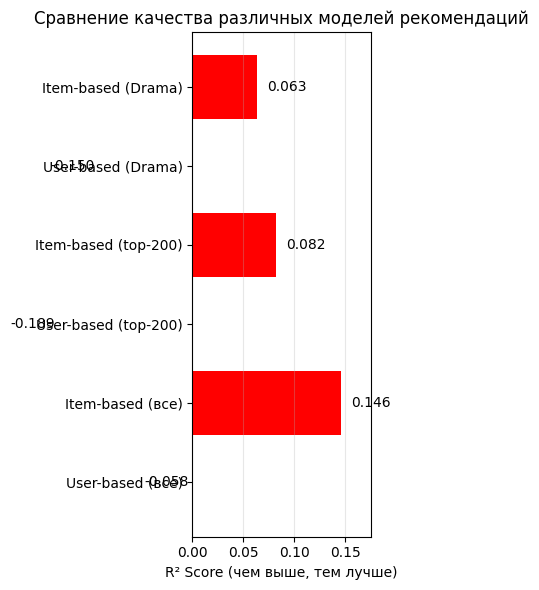

In [10]:

results = {
    'Модель': ['User-based (все)', 'Item-based (все)',
               'User-based (top-200)', 'Item-based (top-200)',
               f'User-based ({genre_name})', f'Item-based ({genre_name})'],
    'R²': [r2_user_orig, r2_item_orig,
           r2_user_top200, r2_item_top200,
           r2_user_genre, r2_item_genre]
}

results_df = pd.DataFrame(results)
print("\n" + "=" * 60)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print("=" * 60)
print(results_df.to_string(index=False))


plt.figure(figsize=(10, 6))
bars = plt.barh(results_df['Модель'], results_df['R²'], color=['blue', 'red']*3)
plt.xlabel('R² Score (чем выше, тем лучше)')
plt.title('Сравнение качества различных моделей рекомендаций')
plt.xlim(0, max(results_df['R²']) * 1.2)


for bar, value in zip(bars, results_df['R²']):
    plt.text(value + 0.01, bar.get_y() + bar.get_height()/2,
             f'{value:.3f}', va='center')

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
print("\n" + "=" * 60)
print("КАК ПОВЫСИТЬ ТОЧНОСТЬ РЕКОМЕНДАЦИЙ?")
print("=" * 60)

improvements = [
    ("1. Учет временных факторов", "Более свежие оценки могут быть релевантнее старых"),
    ("2. Контекстные признаки", "Время суток, день недели, сезон покупки/просмотра"),
    ("3. Демографические данные", "Возраст, пол, профессия пользователей"),
    ("4. Контентные признаки фильмов", "Актеры, режиссеры, год выпуска, бюджет"),
    ("5. Гибридные подходы", "Комбинация коллаборативной и контентной фильтрации"),
    ("6. Глубокое обучение", "Autoencoders, нейросетевые матричные разложения"),
    ("7. Регуляризация", "L1/L2 регуляризация для борьбы с переобучением"),
    ("8. Ансамблирование", "Комбинация нескольких моделей (усреднение, стекинг)"),
    ("9. Учет неявных откликов", "Просмотры, время просмотра, добавление в избранное"),
    ("10. Факторизация матриц", "SVD, NMF, PMF методы"),
    ("11. Градиентный бустинг", "XGBoost, LightGBM для регрессии оценок"),
    ("12. Учет социальных связей", "Рекомендации друзей, подписчиков"),
]

for imp, desc in improvements:
    print(f"{imp}: {desc}")


КАК ПОВЫСИТЬ ТОЧНОСТЬ РЕКОМЕНДАЦИЙ?
1. Учет временных факторов: Более свежие оценки могут быть релевантнее старых
2. Контекстные признаки: Время суток, день недели, сезон покупки/просмотра
3. Демографические данные: Возраст, пол, профессия пользователей
4. Контентные признаки фильмов: Актеры, режиссеры, год выпуска, бюджет
5. Гибридные подходы: Комбинация коллаборативной и контентной фильтрации
6. Глубокое обучение: Autoencoders, нейросетевые матричные разложения
7. Регуляризация: L1/L2 регуляризация для борьбы с переобучением
8. Ансамблирование: Комбинация нескольких моделей (усреднение, стекинг)
9. Учет неявных откликов: Просмотры, время просмотра, добавление в избранное
10. Факторизация матриц: SVD, NMF, PMF методы
11. Градиентный бустинг: XGBoost, LightGBM для регрессии оценок
12. Учет социальных связей: Рекомендации друзей, подписчиков


In [12]:

import pickle
with open('lab7_results.pkl', 'wb') as f:
    pickle.dump({
        'results_df': results_df,
        'train_shape': train.shape,
        'top200_count': len(top_200_movies_idx),
        'genre_count': len(genre_movies_idx)
    }, f)
print("Результаты сохранены в lab7_results.pkl")

Результаты сохранены в lab7_results.pkl
